# Figures

In [13]:
import os
import nibabel as nb
import numpy as np
out_dir = '/home/shared/2018/visual/hcp_cerebellum/'

fig_dir = '/home/shared/2018/visual/hcp_cerebellum/figs/'

try:
    os.mkdir(fig_dir)
except:
    print 'figdir already exists'
    
import h5py
import matplotlib.pyplot as pl
import seaborn as sn
sn.set_style('ticks')
import glob
%matplotlib inline

import colorsys as cs

dims = {
    'ang':0,
    'ecc':1,
    'gain':2,
    'meanvol':3,
    'r2':4,
    'rfsize':5
}





figdir already exists


In [14]:
def p_val_from_bootstrap_dist(distribution,test_value=0,two_tailed=True):
    """
    Finds p-value for hypothesis that the distribution is not different 
    from the test_value.

    :param distribution: distribution of bootstrapped parameter
    :type distribution: 1-D array
    :param test_value: value to test distribution against
    :type test_value: float
    :param two_tailed: if True, returns two-tailed test, else one-tailed
    :type two_tailed: bool

    :return p-val: p-val
    :type p-val: float
    """

    # see which part of the distribution falls below / above test value:
    proportion_smaller_than_test_value = np.sum(np.array(distribution) < test_value) / len(distribution)
    proportion_larger_than_test_value = np.sum(np.array(distribution) > test_value) / len(distribution)

    # take minimum value as p-val:
    p = np.min([proportion_smaller_than_test_value,proportion_larger_than_test_value])

    # this yields a one-tailed test, so multiply by 2 if we want a two-tailed p-val:
    if two_tailed:
        p*=2

    return p

def get_ci(distribution,ci_factor):

    from scipy import stats
    
    # convert ci factor to percentile
    perc_low = (stats.norm.sf(ci_factor))*100
    perc_high = (1 - (stats.norm.sf(ci_factor)))*100
    ci_low = np.percentile(distribution,perc_low)
    ci_high = np.percentile(distribution,perc_high)

    return [ci_low,ci_high]

def bootstrap_linear_fit(x_data,y_data,weights=None,test_value=0,ci_factor = 1.96,two_tailed=True,reps=1000):
    """
    Fits linear regression to data, either weighted or not. 
    Returns bootstrapped CIs for slope and intercept


    """
    # # set weights to one if none provided 
    if weights is None:
        weights = np.ones(len(x_data))

    # get random ints for random indices
    permute_indices = np.random.randint(0, len(x_data), size = (len(x_data), int(reps))).T

    slope_bootstrap_distr=[]
    intercept_bootstrap_distr=[]
    # loop over permutes
    for fold in permute_indices:
        # compute weighted linear fit
        slope,intercept=np.polyfit(x_data[fold], y_data[fold], 1,w=weights[fold])
        slope_bootstrap_distr.append(slope)
        intercept_bootstrap_distr.append(intercept)

    # get centers for slope and intercept by fitting to all data
    mean_slope,mean_intercept=np.polyfit(x_data, y_data, 1,w=weights)
    # slope distribution diagnostics
    ci_slope = get_ci(slope_bootstrap_distr,ci_factor)
    # ci_slope = np.std(slope_bootstrap_distr)*ci_factor
    p_slope = p_val_from_bootstrap_dist(slope_bootstrap_distr,test_value,two_tailed)

    # intercept distribution diagnostics
    # ci_intercept = np.std(intercept_bootstrap_distr)*ci_factor
    ci_intercept = get_ci(intercept_bootstrap_distr,ci_factor)
    p_intercept = p_val_from_bootstrap_dist(intercept_bootstrap_distr,test_value,two_tailed)

    return mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept

# create retmap snapshots for different maskings:

# avg subject plots

In [15]:
masktype = 'r2_spill_fix'

mask_names ={
'left_VI':1,
'right_VI':5,
'left_VIIb':2,
'right_VIIb':7,
'left_VIIIb':3,
'right_VIIIb':6,
'left_crusI':4,
}

roi_combs = {
    'VI':[1,5],
    'VIIb':[2,7],
    'VIIIb':[3,6],
    'crus':[4]
}

stim_radius = 8
sub_types = ['avg','wavg','per']
n_vox_per = 250

roi_order = ['left_VI','right_VI','left_VIIb','right_VIIb','left_VIIIb','right_VIIIb']
roi_comb_order = ['VI','VIIb','VIIIb']

In [16]:
def get_ecc_lim(mask,sub_type,plot_type=None):
    
    if plot_type == None:
        plot_type = 'zoomed_in'
        
    # determine ecc limit
    if plot_type == 'zoomed_out':
        maxecc = 8
    elif plot_type == 'zoomed_in':
        if (mask in ['left_VI','right_VI']) + (mask =='VI'):
            if sub_type == 'avg':
                maxecc = 0.5
            elif sub_type == 'per':
                maxecc=8
            elif sub_type == 'wavg':
                maxecc = 3
        elif ('VIIb' in mask) + (mask=='VIIb'):
            if sub_type == 'per':
                maxecc = 8
            else:
                maxecc = 4
        elif ('VIIIb' in mask) + (mask=='VIIIb'):
            maxecc = 8
    return maxecc

def get_roi_color(mask):
    # determine roi color
    if (mask in ['left_VI','right_VI']) + (mask =='VI'):
        c = '#1B75BC'
    elif ('VIIb' in mask) + (mask=='VIIb'):
        c = 'orange'
    elif ('VIIIb' in mask) + (mask=='VIIIb'):
        c = 'c'
    return c
    
def get_size_lim(mask,sub_type):
    if mask == 'VI':  
        if sub_type in ['avg','wavg']:
            max_size= 2
        elif sub_type == 'per':
            max_size = 5
    elif mask == 'VIIb':
        if sub_type in ['avg','wavg']:
            max_size= 5
        elif sub_type == 'per':
            max_size = 10
    elif mask == 'VIIIb':
        if sub_type in ['avg','wavg']:
            max_size= 10
        elif sub_type == 'per':
            max_size = 10
            
    return max_size

def two_d_gauss(xo, yo, sigma, amplitude = 1, theta=0,res=101,max_eccentricity=8):


    X = np.linspace(-max_eccentricity, max_eccentricity, res)
    Y = np.linspace(-max_eccentricity, max_eccentricity, res)
    MG = np.meshgrid(X, Y)

    (x,y) = MG    
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    gauss = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

    return gauss

# visualize pRF coverage

/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


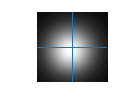

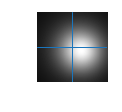

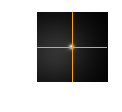

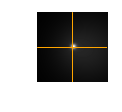

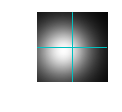

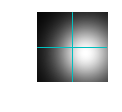

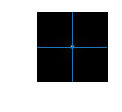

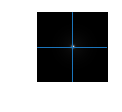

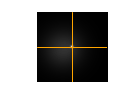

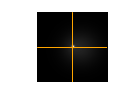

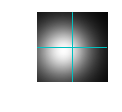

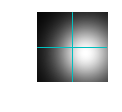

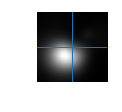

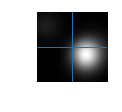

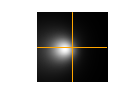

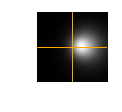

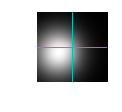

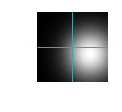

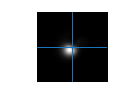

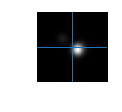

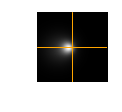

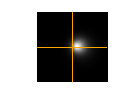

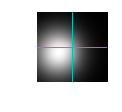

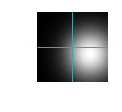

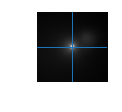

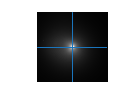

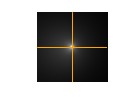

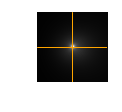

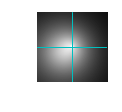

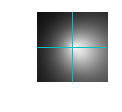

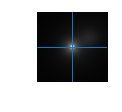

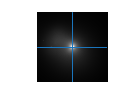

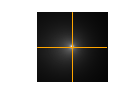

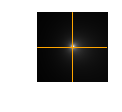

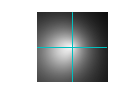

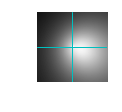

In [17]:
# imshow of coverage
pl.close('all')
for sub_type in sub_types:#,'wavg','per']:#,'per']:
    for plot_type in ['zoomed_in','zoomed_out']:
        for mi,mask in enumerate(roi_order):
            
            # setup figure
            f1 = pl.figure(figsize=(1.25,1.25))
            s1 = f1.add_subplot(1,1,1,aspect='equal')
            
            # get this mask
            roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

            # get data
            if sub_type in ['avg','wavg']:

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
                xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                sizes = np.ravel(data[roimask,dims['rfsize']])
                r2s = np.ravel(data[roimask,dims['r2']])

            elif sub_type == 'per':

                all_xs = []
                all_ys = []
                all_sizes=[]

                all_r2s=[]

                for sj in range(181):

                    data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

                    xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    sizes = np.ravel(data[roimask,dims['rfsize']])
                    r2s = np.ravel(data[roimask,dims['r2']])

                    all_xs.append(xs)
                    all_ys.append(ys)
                    all_sizes.append(sizes)
                    all_r2s.append(r2s)

                xs = np.ravel(all_xs)
                ys = np.ravel(all_ys)                    
                sizes = np.ravel(all_sizes)                    
                r2s = np.ravel(all_r2s)   
                

            # determine ecc limit and roi color
            maxecc = get_ecc_lim(mask,sub_type,plot_type)
            c = get_roi_color(mask)

            # determine coverage
            stim_radius = maxecc
            scope = 1
            v = (sizes>0)*(~np.isnan(sizes))
            if sub_type == 'per':
                # random selection of voxels
                indices = np.hstack([np.ones(n_vox_per),np.zeros(v.sum()-n_vox_per)]).astype(bool)
                np.random.shuffle(indices)          
                v[v==True] *= indices
            
            res = 501
            coverage = []
            for i,x,y,sigma,r2 in zip(range(v.sum()),xs[v],ys[v],sizes[v],r2s[v]):
                coverage.append(two_d_gauss(x,y,sigma,r2,max_eccentricity=stim_radius*scope,res=res))
                xr = (x/scope+stim_radius)/(stim_radius*2)*res
                yr = (y/scope+stim_radius)/(stim_radius*2)*res
                sr = (sigma/(stim_radius*scope*2))*res
            cov = np.nanmean(coverage,axis=0)

            # plot coverage
            pl.imshow(cov,interpolation='nearest',cmap='gray',vmin=0,origin='lowerleft')

            # add circle of stim radius if scope is greater than 1
            if scope > 1:
                s.add_artist(pl.Circle((res/2,res/2),res/2/scope, color=c,fill=False))

            # add axis lines
            pl.axhline(res/2,lw=1,color=c)
            pl.axvline(res/2,lw=1,color=c)
            pl.axis('off')

            # save
            f1.savefig(os.path.join(fig_dir,'coverage_avg_subject_%s_%s_%s.png'%(plot_type,sub_type,mask)),dpi=500)


# visualize pRF center + size distribution

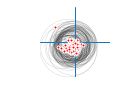

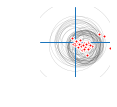

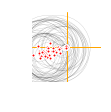

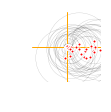

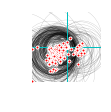

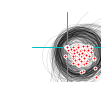

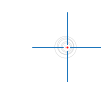

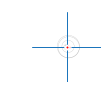

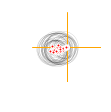

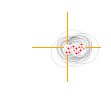

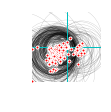

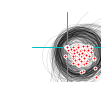

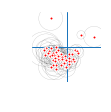

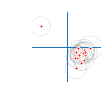

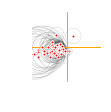

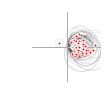

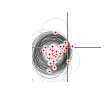

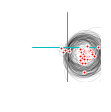

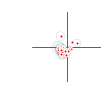

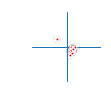

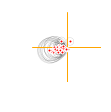

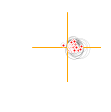

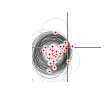

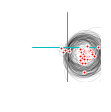

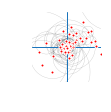

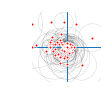

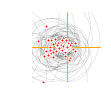

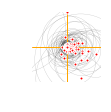

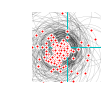

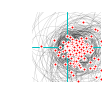

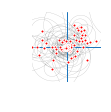

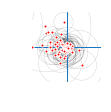

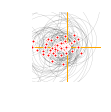

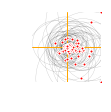

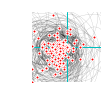

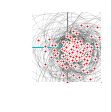

In [18]:
# scatter plot
pl.close('all')
for sub_type in sub_types:
    for plot_type in ['zoomed_in','zoomed_out']:

        for mi,mask in enumerate(roi_order):
            f = pl.figure(figsize=(1.25,1.25))

            s = f.add_subplot(1,1,1,aspect='equal')

            roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

            roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))

            if sub_type in ['avg','wavg']:

                alpha = 1
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
                xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                sizes = np.ravel(data[roimask,dims['rfsize']])
                r2s = np.ravel(data[roimask,dims['r2']])


            elif sub_type == 'per':

                alpha = 1#0.1

                all_xs = []
                all_ys = []
                all_sizes=[]

                all_r2s=[]

                for sj in range(181):

                    data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

                    xs = np.cos(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    ys = np.sin(np.radians(np.ravel(data[roimask,dims['ang']]))) * np.ravel(data[roimask,dims['ecc']])
                    sizes = np.ravel(data[roimask,dims['rfsize']])
                    r2s = np.ravel(data[roimask,dims['r2']])

                    all_xs.append(xs)
                    all_ys.append(ys)
                    all_sizes.append(sizes)
                    all_r2s.append(r2s)


                xs = np.ravel(all_xs)
                ys = np.ravel(all_ys)                    
                sizes = np.ravel(all_sizes)                    
                r2s = np.ravel(all_r2s)                    

            v = (sizes>0)
            if sub_type == 'per':
                indices = np.hstack([np.ones(n_vox_per),np.zeros(v.sum()-n_vox_per)]).astype(bool)
                np.random.shuffle(indices)          
                v[v==True] *= indices

            # determine ecc limit and roi color
            maxecc = get_ecc_lim(mask,sub_type,plot_type)
            c = get_roi_color(mask)

            stim_radius = maxecc
            for x,y,sigma,r2 in zip(xs[v],ys[v],sizes[v],r2s[v]):
                s.add_artist(pl.Circle((x,y),sigma, color='k',fill=False,alpha=0.25))

            if scope > 1:
                s.add_artist(pl.Circle((res/2,res/2),res/2/scope, color='c',fill=False))

            pl.axhline(0,lw=1,color=c)
            pl.axvline(0,lw=1,color=c)

            pl.plot(xs[v],ys[v],'o',color='r',ms=3,mec='w',mew=1,alpha=alpha)
            pl.xlim(-maxecc,maxecc)
            pl.ylim(-maxecc,maxecc)   

            pl.axis('off')
            f.savefig(os.path.join(fig_dir,'prf_scatter_%s_avg_subject_%s_%s.png'%(mask,plot_type,sub_type)),dpi=500)

# create eccentricity-size plot

0
0
0
0
0
0
0
0
0


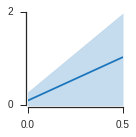

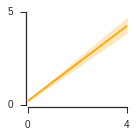

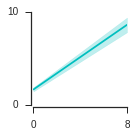

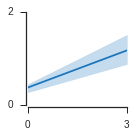

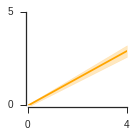

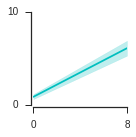

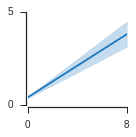

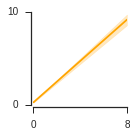

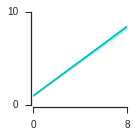

In [23]:
# eccen-size plot
for sub_type in sub_types:#['per']:#['wavg','avg','per']:

    for mi,mask in enumerate(roi_comb_order):
        f = pl.figure(figsize=(2,2))
        s = f.add_subplot(1,1,1)

        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        
        roimask = roimask.astype(bool)
        
        # determine ecc limit and roi color
        maxecc = get_ecc_lim(mask,sub_type)
        maxplotsize = get_size_lim(mask,sub_type)
        c = get_roi_color(mask)  

        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            sizes = np.ravel(data[roimask,dims['rfsize']])
            eccs = np.ravel(data[roimask,dims['ecc']])
        
        elif sub_type == 'per':

            all_sizes = []
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_sizes.append(np.ravel(data[roimask,dims['rfsize']]))
                all_eccs.append(np.ravel(data[roimask,dims['ecc']]))
            eccs = np.ravel(all_eccs)
            sizes = np.ravel(all_sizes)  

        elif sub_type == 'fits_per':
            all_fits = []
            for sj in range(181):
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                r2s = np.ravel(data[roimask,dims['r2']])
                sizes = np.ravel(data[roimask,dims['rfsize']])
                eccs = np.ravel(data[roimask,dims['ecc']])
                v = (eccs < maxecc)#*(sizes<maxsize)

                if v.sum() > 2:
                    p=np.polyfit(eccs[v], sizes[v], 1,w=r2s[v])
                    fit = np.polyval(p,np.linspace(0,maxecc,15))
                    all_fits.append(fit)
            
#             print np.shape(all_fits)
            meanfit = np.mean(all_fits,axis=0)
            sefit = (np.std(all_fits,axis=0)*1.96)/np.sqrt(np.shape(all_fits)[0])
            pl.plot(np.linspace(0,maxecc,15),meanfit,color=c)
            pl.fill_between(np.linspace(0,maxecc,15),meanfit-sefit,meanfit+sefit,alpha=0.5,color=c)
            
        from scipy.stats import binned_statistic

        if sub_type != 'fits_per':

            
            v = (eccs < maxecc)#*(sizes<maxsize)# * (eccs>.15) * (r2>9.8)
            mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])            
            fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
            fit_high = np.polyval([ci_slope[1],ci_intercept[1]],np.linspace(0,maxecc,15))
            fit_low = np.polyval([ci_slope[0],ci_intercept[0]],np.linspace(0,maxecc,15))

            print p_slope
            pl.plot(np.linspace(0,maxecc,15),fit,color=c)
            pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.25,color=c)

        pl.xlim(0,maxecc)  
        pl.ylim(0,maxplotsize)
        pl.xticks([0,maxecc])
        pl.yticks([0,maxplotsize])

        sn.despine(offset=2)

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'prf_eccsize_%s_%s.png'%(sub_type,mask)),dpi=500)

# create eccentricity histogram

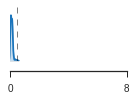

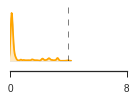

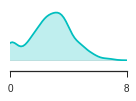

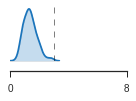

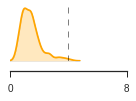

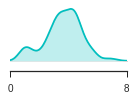

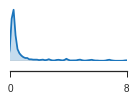

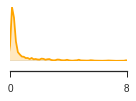

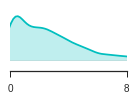

In [20]:
# ecc histogram
for sub_type in sub_types:

    # first create a plot for the average subject
    for mi,mask in enumerate(roi_comb_order):

        # setup figure
        f = pl.figure(figsize=(2,1.5))
        s = f.add_subplot(1,1,1)
        
        # get mask
        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data())
        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==subroi)
            roimask[this_mask] = 1
        roimask = roimask.astype(bool)

        # get data
        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            eccs = np.ravel(data[roimask,dims['ecc']])

        elif sub_type == 'per':
            all_eccs = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_eccs.append(np.ravel(data[roimask,dims['ecc']]))

            eccs = np.ravel(all_eccs)
                
        maxecc = get_ecc_lim(mask,sub_type)
        maxplotsize = get_size_lim(mask,sub_type)
        c = get_roi_color(mask)
        
        try: 
            sn.kdeplot(eccs[~np.isnan(eccs)],shade=True,color=c)#,color = ['b'])
        except:
            print 'could not plot'
            
        pl.axvline(maxecc,ls='--',color='k',lw=0.5) 
        pl.xlim(0,stim_radius)
        pl.ylim(0,s.get_ylim()[1])
        pl.xticks([0,stim_radius])
        pl.yticks([])
        sn.despine(offset=10,left=True)

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'ecc_histograms_%s_%s.pdf'%(sub_type,mask)),dpi=500)

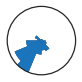

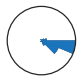

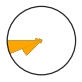

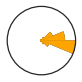

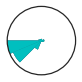

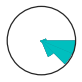

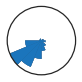

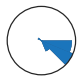

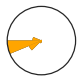

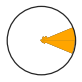

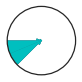

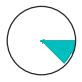

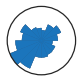

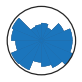

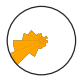

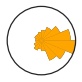

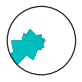

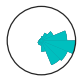

In [21]:
# polar histogram
for sub_type in sub_types:

    # first create a plot for the average subject
    for mi,mask in enumerate(roi_order):
        f = pl.figure(figsize=(1.25,1.25))
        s = f.add_subplot(1,1,1,projection='polar')
        roimask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==(mask_names[mask]))


        c = get_roi_color(mask)
        
        if sub_type in ['avg','wavg']:

            data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%s.nii'%sub_type)).get_data()
            angles = np.ravel(data[roimask,dims['ang']])

        elif sub_type == 'per':
            all_angles = []
            for sj in range(181):

                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                all_angles.append(np.ravel(data[roimask,dims['ang']]))

            angles = np.ravel(all_angles)
        
        angles = angles[~np.isnan(angles)]

        bins_number = 16
        bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
        radangs = np.radians(angles)
        n, _, _ = pl.hist(radangs, bins)

        width = 2 * np.pi / bins_number
        pl.bar(bins[:bins_number], n, width=width, bottom=0.0,ec=c,color=c)
#         for bar in bars:
#             bar.set_alpha(0.5)
        pl.xticks([])
        pl.yticks([])
        pl.ylim(0,np.max(n))

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'polar_histograms_%s_%s.pdf'%(sub_type,mask)))

# individual subject plots

In [22]:
# import colorsys
# colors = np.array([colorsys.hsv_to_rgb(c,0.6,0.9) for c in np.linspace(0,1,12)])[:-2]

f = pl.figure(figsize=(2,2))
coefs = []

for sj in range(5):
    for ei, eccrange in enumerate([8,12]):

        s = f.add_subplot(1,2,ei+1)

        # first create a plot for the average subject
        data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()

        eccs = data[roimask,dims['ecc']]
        sizes = data[roimask,dims['rfsize']]

        v = (eccs<eccrange)*(~np.isnan(eccs))
        mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])
        
        x = np.linspace(0,eccrange,10)
        
        fit = mean_intercept + mean_slope * x
        high_fit = ci_intercept[1] + ci_slope[1] * x
        low_fit = ci_intercept[0] + ci_slope[0] * x

        pl.fill_between(x,high_fit,low_fit,color=colors[sj],alpha=0.1)
        pl.plot(x,fit,c=colors[sj])
        
        print 'slope is %.3f greater than 0 with p = %.3f'%(mean_slope,p_slope)

#         pl.plot(x,c.intercept_[0]+c.coef_[0][0]*x,c=colors[si])


    #         sn.regplot(eccs[v],sizes[v],color = ['b','k'][ei])
    #         # pl.plot(xs,ys,'o',color='k',ms=3,mec='w',mew=1)

        pl.xlim(0,eccrange)
        pl.ylim(0,maxsize)
        pl.xticks([0,eccrange])
        pl.yticks([0,maxsize])
        sn.despine(offset=10)
    
pl.tight_layout()
f.savefig(os.path.join(fig_dir,'ecc_size_all_subjects_together.pdf'))     

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
could not fit
could not fit


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

could not fit
0


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0
could not fit


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
0
could not fit


/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/vanes/anaconda2/envs/analysis/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly co

0
could not fit


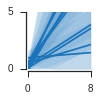

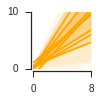

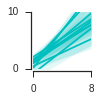

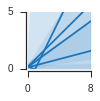

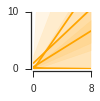

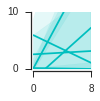

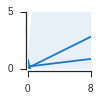

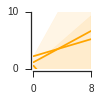

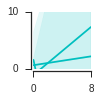

In [34]:

# eccen-size plot
for sgi,sjg in zip([range(10),range(88,93),range(176,181)],['high','mid','low']):
    for mi,mask in enumerate(roi_comb_order):
        f = pl.figure(figsize=(1.5,1.5))
        s = f.add_subplot(1,1,1)

        roimask = np.zeros_like(nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data())

        for subroi in roi_combs[mask]:
            this_mask = (nb.load(os.path.join(out_dir,'masks','cer_retmaps','all_masks_together.nii')).get_data()==subroi)
            roimask[this_mask] = 1

        roimask = roimask.astype(bool)

        # determine ecc limit and roi color
        maxecc = get_ecc_lim(mask,sub_type)
        maxplotsize = get_size_lim(mask,sub_type)
        c = get_roi_color(mask)  

        for sj in sgi:

            try:
                data = nb.load(os.path.join(out_dir,'masked_niftis',masktype,'prfresults_subject_rank_%d.nii'%sj)).get_data()
                sizes = np.ravel(data[roimask,dims['rfsize']])
                eccs = np.ravel(data[roimask,dims['ecc']])
                v = (eccs < maxecc)#*(sizes<maxsize)

                mean_slope, ci_slope, p_slope, mean_intercept, ci_intercept, p_intercept = bootstrap_linear_fit(eccs[v],sizes[v])            
                fit = np.polyval([mean_slope,mean_intercept],np.linspace(0,maxecc,15))
                fit_high = np.polyval([ci_slope[1],ci_intercept[1]],np.linspace(0,maxecc,15))
                fit_low = np.polyval([ci_slope[0],ci_intercept[0]],np.linspace(0,maxecc,15))

                print p_slope
                pl.plot(np.linspace(0,maxecc,15),fit,color=c)
                pl.fill_between(np.linspace(0,maxecc,15),fit_low,fit_high,alpha=0.1,color=c)
            except:
                print 'could not fit'

        pl.xlim(0,maxecc)  
        pl.ylim(0,maxplotsize)
        pl.xticks([0,maxecc])
        pl.yticks([0,maxplotsize])

        sn.despine(offset=2)

        pl.tight_layout()
        f.savefig(os.path.join(fig_dir,'prf_eccsize_all_%s_%s.png'%(sjg,mask)),dpi=500)